# How to Use Reservoir Computing Modules
The overall process is:
1. Generate 2 datasets: `training_data` and `reservoir_transient_data`. 
2. The reservoir is trained using `training_data`. 
3. Using `W_out` from step 2, run a `transient_forecast_res` on 
`reservoir_transient_data`.
4. Use `transient_forecast_res` to predict the dynamical system over the 
reservoir transient period, call it `transient_preds`. 
5. Generate `test_data` whose initial condition is the last data point in `reservoir_transient_data`.
6. Generate `forecast_res` initialised using the last reservoir state of `transient_forecast_res`.
5. Use `forecast_res` to predict the system, and evaluate these predictions against 
the `test_data`. 

In [162]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "white"

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from data import data
from reservoir import reservoir as res
from error import error

In [163]:
LAMBDA = 0.9056
SEED = 42
STATE = np.random.RandomState(SEED)

NUM_TRIALS = 100

# reservoir dimension
N = 100

In [164]:
hyperparams = {
    'GAMMA': 7.7,
    'SIGMA': 0.81,
    'RHO_IN': 0.37,
    'K': 3,
    'RHO_R': 0.41
}

simulation_parameters = {
    "DEL_T": 0.02,          # time step size
    "STEPS": 30000,         # total steps
    "TRANSIENT": 10000,       # TRANSIENT 
    # n = STEPS - TRANSIENT
    "ALPHA": 0.001,         # Tikhonov regularisation constant
    "d": 3,
    "INITIAL_STATE_RANGE": 5
}

## Datasets

In [165]:
training_ic = STATE.choice(np.linspace(-5, 5), 3)
reservoir_transient_ic = STATE.choice(np.linspace(-5, 5), 3)

training_data = data.generate_lorenz_63(
    initial_state=training_ic,
    del_t=simulation_parameters["DEL_T"],
    steps=simulation_parameters["STEPS"],
    transient=simulation_parameters["TRANSIENT"]
)

reservoir_transient_data = data.generate_lorenz_63(
    initial_state=reservoir_transient_ic,
    del_t=simulation_parameters["DEL_T"],
    steps=simulation_parameters["STEPS"],
    transient=simulation_parameters["TRANSIENT"]
)

## Train Reservoir

In [166]:
W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, simulation_parameters["d"]), state=STATE)
W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), state=STATE)

In [167]:
training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=simulation_parameters["DEL_T"],
    adjust_for_symmetry=True
)

In [168]:
W_out = res.generate_W_out(
    data=training_data,
    res=training_res,
    alpha=simulation_parameters["ALPHA"]
)

## Generate Transient Reservoir Preds

In [169]:
unmodified_transient_forecast_res, transient_forecast_res = res.generate_forecast_reservoir(
    r_0=np.dot(W_in, reservoir_transient_data[0]),
    data=reservoir_transient_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    W_out=W_out,
    delta_t=simulation_parameters["DEL_T"],
    adjust_for_symmetry=True
)

In [170]:
transient_preds = res.readout_network(res=transient_forecast_res, W_out=W_out)

In [171]:
transient_preds

array([[  6.46053786, -21.68900468,  17.61523967],
       [  4.24440328, -18.12307078,  12.96374857],
       [  2.67798571, -17.88754604,  10.67305853],
       ...,
       [-14.68705026, -21.45551633,  27.25711101],
       [-15.83181455, -20.55460229,  32.13614733],
       [-16.47229694, -18.05024227,  36.53533883]])

## Evaluate Actual Prediction

In [172]:
test_ic = transient_preds[-1]
test_data = data.generate_lorenz_63(
    initial_state=test_ic,
    del_t=simulation_parameters["DEL_T"],
    steps=simulation_parameters["STEPS"],
    transient=0
)

In [173]:
unmodified_forecast_res, forecast_res = res.generate_forecast_reservoir(
    r_0=unmodified_transient_forecast_res[-1],
    data=test_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    W_out=W_out,
    delta_t=simulation_parameters["DEL_T"],
    adjust_for_symmetry=True
)

In [174]:
preds = res.readout_network(res=forecast_res, W_out=W_out)
preds

array([[-16.47229694, -18.05024227,  36.53533883],
       [-16.44067514, -14.28605163,  39.9056703 ],
       [-15.60761041,  -9.8416954 ,  41.58060044],
       ...,
       [ -5.11227885,  -8.656629  ,  13.95625718],
       [ -5.87688003,  -9.99489893,  14.22932001],
       [ -6.75667407, -11.48192758,  14.81135711]])

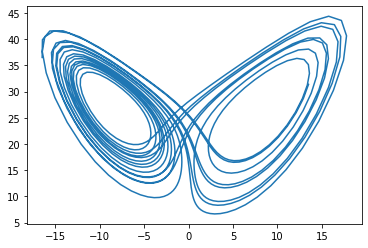

In [175]:
start = data.lyapunov_to_steps(0, LAMBDA, simulation_parameters["DEL_T"])
end = data.lyapunov_to_steps(15, LAMBDA, simulation_parameters["DEL_T"])
x_range = LAMBDA * simulation_parameters["DEL_T"] * np.array(range(start, end))
plt.plot(preds[start:end, 0], preds[start:end, 2])

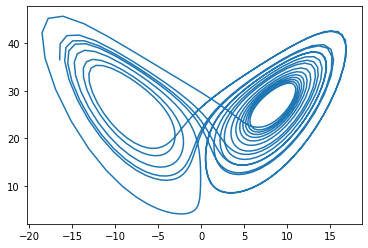

In [176]:
plt.plot(test_data[start:end, 0], test_data[start:end, 2])

Text(0, 0.5, 'x')

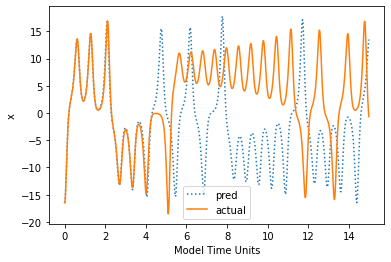

In [177]:
plt.plot(x_range, preds[start:end, 0], label="pred", linestyle="dotted")
plt.plot(x_range, test_data[start:end, 0], label="actual")
plt.legend()
plt.xlabel("Model Time Units")
plt.ylabel("x")

Text(0, 0.5, 'y')

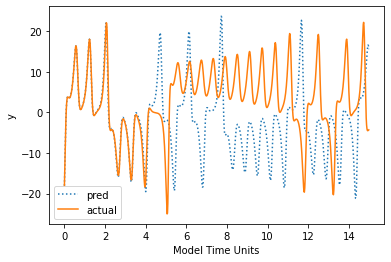

In [178]:
plt.plot(x_range, preds[start:end, 1], label="pred", linestyle="dotted")
plt.plot(x_range, test_data[start:end, 1], label="actual")
plt.legend()
plt.xlabel("Model Time Units")
plt.ylabel("y")

Text(0, 0.5, 'z')

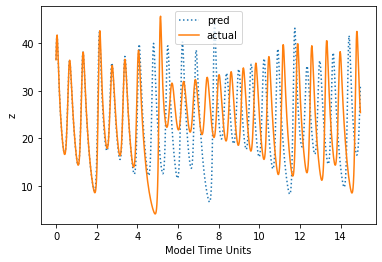

In [179]:
plt.plot(x_range, preds[start:end, 2], label="pred", linestyle="dotted")
plt.plot(x_range, test_data[start:end, 2], label="actual")
plt.legend()
plt.xlabel("Model Time Units")
plt.ylabel("z")

In [180]:
print(error.RMSE(test_data, preds))
print(error.griffith_epsilon_1(test_data, preds, delta_t=simulation_parameters["DEL_T"], LAMBDA=LAMBDA))
print(error.griffith_epsilon(test_data, preds, delta_t=simulation_parameters["DEL_T"], LAMBDA=LAMBDA))

[0.81129813 0.92127189 0.86317022]
3.9876215097757615
0.9873185122878755


# Comparison of Computation Time

In [182]:
LAMBDA = 0.9056
N = 100
hyperparams = {
    'GAMMA': 7.7,
    'SIGMA': 0.81,
    'RHO_IN': 0.37,
    'K': 3,
    'RHO_R': 0.41
}
simulation_parameters = {
    "DEL_T": 0.02,          # time step size
    "STEPS": 30000,         # total steps
    "TRANSIENT": 10000,       # TRANSIENT 
    # n = STEPS - TRANSIENT
    "ALPHA": 0.001,         # Tikhonov regularisation constant
    "d": 3,
    "INITIAL_STATE_RANGE": 5
}

In [194]:
# with transient reservoir
def trial_with_transient_res(seed):
    start = datetime.now()
    
    state = np.random.RandomState(seed)
    
    training_ic = state.choice(np.linspace(-5, 5), 3)
    reservoir_transient_ic = state.choice(np.linspace(-5, 5), 3)

    training_data = data.generate_lorenz_63(
        initial_state=training_ic,
        del_t=simulation_parameters["DEL_T"],
        steps=simulation_parameters["STEPS"],
        transient=simulation_parameters["TRANSIENT"]
    )

    reservoir_transient_data = data.generate_lorenz_63(
        initial_state=reservoir_transient_ic,
        del_t=simulation_parameters["DEL_T"],
        steps=simulation_parameters["STEPS"],
        transient=simulation_parameters["TRANSIENT"]
    )

    W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, simulation_parameters["d"]), state=state)
    W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), state=state)

    training_res = res.generate_training_reservoir(
        data=training_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        delta_t=simulation_parameters["DEL_T"],
        adjust_for_symmetry=True
    )

    W_out = res.generate_W_out(
        data=training_data,
        res=training_res,
        alpha=simulation_parameters["ALPHA"]
    )

    unmodified_transient_forecast_res, transient_forecast_res = res.generate_forecast_reservoir(
        r_0=np.dot(W_in, reservoir_transient_data[0]),
        data=reservoir_transient_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        W_out=W_out,
        delta_t=simulation_parameters["DEL_T"],
        adjust_for_symmetry=True
    )

    transient_preds = res.readout_network(res=transient_forecast_res, W_out=W_out)

    test_ic = transient_preds[-1]
    test_data = data.generate_lorenz_63(
        initial_state=test_ic,
        del_t=simulation_parameters["DEL_T"],
        steps=simulation_parameters["STEPS"],
        transient=0
    )

    unmodified_forecast_res, forecast_res = res.generate_forecast_reservoir(
        r_0=unmodified_transient_forecast_res[-1],
        data=test_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        W_out=W_out,
        delta_t=simulation_parameters["DEL_T"],
        adjust_for_symmetry=True
    )

    preds = res.readout_network(res=forecast_res, W_out=W_out)

    losses = {
        "RMSE": error.RMSE(test_data, preds),
        "griffith_epsilon_1": error.griffith_epsilon_1(test_data, preds, simulation_parameters["DEL_T"], LAMBDA),
        "griffith_epsilon": error.griffith_epsilon(test_data, preds, simulation_parameters["DEL_T"], LAMBDA),
    }

    end = datetime.now()

    time_taken = (end - start).total_seconds() / 60

    return {
        "W_in": W_in,
        "W_r": W_r,
        "W_out": W_out,
        "training_data": training_data,
        "reservoir_transient_data": reservoir_transient_data,
        "test_data": test_data,
        "preds": preds,
        "loss": losses,
        "mins": time_taken
    }

In [193]:
trial_with_transient_res(42)

{'W_in': array([[ 0.03820075,  0.13833954, -0.07952222],
        [-0.07189575, -0.35765796,  0.13010561],
        [-0.05859951, -0.1016355 , -0.08617512],
        [ 0.08182793,  0.0167318 , -0.07056314],
        [-0.08217475,  0.12970451, -0.1398505 ],
        [-0.02214431, -0.03141177,  0.05330187],
        [ 0.38035106,  0.16340928,  0.        ],
        [ 0.10109607,  0.02346032, -0.01583225],
        [-0.0412211 , -0.06306145,  0.14472003],
        [ 0.0443671 , -0.05271776,  0.        ],
        [ 0.07969261,  0.12153276, -0.02836101],
        [-0.08535406,  0.        , -0.06559895],
        [-0.02541671,  0.11123479,  0.        ],
        [ 0.18566926,  0.13319871,  0.10891702],
        [ 0.46166736, -0.1260015 , -0.19422694],
        [ 0.1427171 ,  0.        ,  0.20232369],
        [-0.07095119, -0.11068277,  0.        ],
        [-0.06869054,  0.0351993 ,  0.04305682],
        [ 0.        , -0.09611107, -0.04485695],
        [ 0.04053887,  0.03573847, -0.19376425],
        [-0.

In [188]:
# without transient reservoir
def trial_no_transient_res(seed):
    start = datetime.now()
    
    state = np.random.RandomState(seed)

    training_ic = state.choice(np.linspace(-5, 5), 3)

    lorenz_data = data.generate_lorenz_63(
        initial_state=training_ic,
        del_t=simulation_parameters["DEL_T"],
        steps=simulation_parameters["STEPS"] * 2,
        transient=simulation_parameters["TRANSIENT"]
    )
    
    n = lorenz_data.shape[0]

    training_data = lorenz_data[0 : n//2]
    test_data = lorenz_data[n//2 : ]

    W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, simulation_parameters["d"]), state=state)
    W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), state=state)

    unmodified_training_res = res.generate_training_reservoir(
        data=training_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        delta_t=simulation_parameters["DEL_T"],
        adjust_for_symmetry=False
    )
    
    training_res = res.generate_training_reservoir(
        data=training_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        delta_t=simulation_parameters["DEL_T"],
        adjust_for_symmetry=True
    )

    W_out = res.generate_W_out(
        data=training_data,
        res=training_res,
        alpha=simulation_parameters["ALPHA"]
    )

    unmodified_forecast_res, forecast_res = res.generate_forecast_reservoir(
        r_0=unmodified_training_res[-1],
        data=test_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        W_out=W_out,
        delta_t=simulation_parameters["DEL_T"],
        adjust_for_symmetry=True
    )

    preds = res.readout_network(res=forecast_res, W_out=W_out)

    losses = {
        "RMSE": error.RMSE(test_data, preds),
        "griffith_epsilon_1": error.griffith_epsilon_1(test_data, preds, simulation_parameters["DEL_T"], LAMBDA),
        "griffith_epsilon": error.griffith_epsilon(test_data, preds, simulation_parameters["DEL_T"], LAMBDA),
    }

    end = datetime.now()

    time_taken = (end - start).total_seconds() / 60

    return {
        "W_in": W_in,
        "W_r": W_r,
        "W_out": W_out,
        "training_data": training_data,
        "test_data": test_data,
        "preds": preds,
        "loss": losses,
        "mins": time_taken
    }

In [189]:
trial_no_transient_res(42)

{'W_in': array([[-0.15221639,  0.04365771,  0.03820075],
        [ 0.13833954, -0.07952222, -0.07189575],
        [-0.35765796,  0.13010561, -0.05859951],
        [-0.1016355 , -0.08617512,  0.08182793],
        [ 0.0167318 , -0.07056314, -0.08217475],
        [ 0.12970451, -0.1398505 , -0.02214431],
        [-0.03141177,  0.05330187,  0.38035106],
        [ 0.16340928,  0.        ,  0.10109607],
        [ 0.02346032, -0.01583225, -0.0412211 ],
        [-0.06306145,  0.14472003,  0.0443671 ],
        [-0.05271776,  0.        ,  0.07969261],
        [ 0.12153276, -0.02836101, -0.08535406],
        [ 0.        , -0.06559895, -0.02541671],
        [ 0.11123479,  0.        ,  0.18566926],
        [ 0.13319871,  0.10891702,  0.46166736],
        [-0.1260015 , -0.19422694,  0.1427171 ],
        [ 0.        ,  0.20232369, -0.07095119],
        [-0.11068277,  0.        , -0.06869054],
        [ 0.0351993 ,  0.04305682,  0.        ],
        [-0.09611107, -0.04485695,  0.04053887],
        [ 0.

In [191]:
with_transient_results = []
no_transient_results = []

for i in range(100):
    with_transient_results.append(trial_with_transient_res(i))
    no_transient_results.append(trial_no_transient_res(i))
    print("Completed: {} / {}".format(i+1, 100))

Completed: 1 / 100
Completed: 2 / 100
Completed: 3 / 100
Completed: 4 / 100


KeyboardInterrupt: 